# NYC High Schools Analysis

Date March 3, 2018

New York City has a significant immigrant population and is very diverse, so comparing demographic data such as race, income, and gender with SAT (Scholastic Aptitude Test) scores is a good way to determine whether the SAT is a fair test.

This notebook is an exercise analysis that looks for any relationships or correlations, if any, among those factors.

The dataset is via NYC Open Data circa 2012 https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4


In [11]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

In [12]:
data

{'ap_2010':         DBN                                         SchoolName  \
 0    01M448                       UNIVERSITY NEIGHBORHOOD H.S.   
 1    01M450                             EAST SIDE COMMUNITY HS   
 2    01M515                                LOWER EASTSIDE PREP   
 3    01M539                     NEW EXPLORATIONS SCI,TECH,MATH   
 4    02M296              High School of Hospitality Management   
 5    02M298                                   Pace High School   
 6    02M300  Urban Assembly School of Design and Construction,   
 7    02M303                         Facing History School, The   
 8    02M305  Urban Assembly Academy of Government and Law, The   
 9    02M308                       Lower Manhattan Arts Academy   
 10   02M400                       HS FOR ENVIRONMENTAL STUDIES   
 11   02M408                       PROFESSIONAL PERFORMING ARTS   
 12   02M411                           BARUCH COLLEGE CAMPUS HS   
 13   02M412                       NYC LAB HS FOR C

# Read in the surveys

Read in the surveys, which are in delimited text files, and do some housecleaning.

In [13]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

In [14]:
data

{'ap_2010':         DBN                                         SchoolName  \
 0    01M448                       UNIVERSITY NEIGHBORHOOD H.S.   
 1    01M450                             EAST SIDE COMMUNITY HS   
 2    01M515                                LOWER EASTSIDE PREP   
 3    01M539                     NEW EXPLORATIONS SCI,TECH,MATH   
 4    02M296              High School of Hospitality Management   
 5    02M298                                   Pace High School   
 6    02M300  Urban Assembly School of Design and Construction,   
 7    02M303                         Facing History School, The   
 8    02M305  Urban Assembly Academy of Government and Law, The   
 9    02M308                       Lower Manhattan Arts Academy   
 10   02M400                       HS FOR ENVIRONMENTAL STUDIES   
 11   02M408                       PROFESSIONAL PERFORMING ARTS   
 12   02M411                           BARUCH COLLEGE CAMPUS HS   
 13   02M412                       NYC LAB HS FOR C

# Add DBN feature

Construct an additional DBN feature 

In [15]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert SAT features  to numeric

In [16]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [17]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [18]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [19]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district feature for mapping

In [20]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [21]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [22]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [23]:
correlations.dropna()

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent                            -0.398750
sped_num                                0.034933
sped_percent                           -0.448170
asian_num           

In [24]:
len(correlations.dropna().values)

59

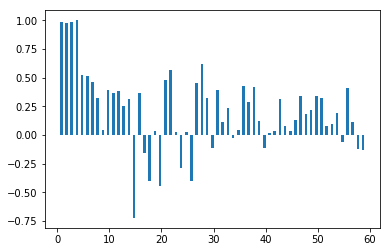

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
from numpy import arange
import numpy as np
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

bar_heights = correlations.dropna().values
bar_positions = np.arange(len(correlations.dropna().values)) + 0.75

ax.bar(bar_positions, bar_heights, 0.5)

plt.show()





In [26]:
dir(ax)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autoscaleXon',
 '_autoscaleYon',
 '_axes',
 '_axes_class',
 '_axes_locator',
 '_axisbelow',
 '_cachedRenderer',
 '_clipon',
 '_clippath',
 '_connected',
 '_contains',
 '_current_image',
 '_facecolor',
 '_frameon',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spines',
 '_get_axis_list',
 '_get_lines',
 '_get_patches_for_fill',
 '_get_view',
 '_gid',
 '_gridOn',
 '_hold',
 '_init_axis',
 '_label',
 '_layoutbox',
 '_left_title',
 '_make_twin_axes',
 '_mouseover',
 '_navigate',
 '_navigate_mode',
 '_o

# Correlation between Safety Scores and SAT

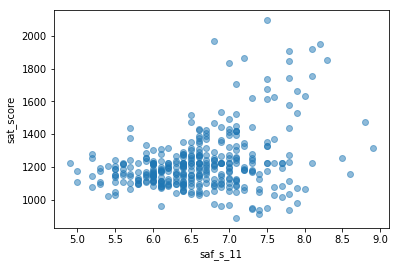

In [27]:
#scatter plot exercise 2
%matplotlib inline
fig2 = plt.figure()
ax2 = fig2.add_subplot(1,1,1)
x=combined['saf_s_11'].values
y=combined['sat_score'].values
ax2.scatter(x,y,alpha=0.5)
ax2.set_xlabel('saf_s_11')
ax2.set_ylabel('sat_score')
plt.show()

In [28]:
y

array([1122.        , 1172.        , 1149.        , 1207.        ,
       1621.        , 1856.        , 1182.        , 1194.        ,
       1156.        , 1111.        , 1293.        , 1269.        ,
       1051.        , 1148.        , 1200.        , 1127.        ,
       1176.        , 1435.        , 1223.43880597, 1223.43880597,
       1223.43880597, 1419.        , 1522.        , 1577.        ,
       1677.        , 1419.        , 1758.        , 1614.        ,
       1170.        , 1306.        , 1233.        , 1223.43880597,
       1223.43880597, 1223.43880597, 1372.        , 1199.        ,
       1227.        , 2096.        , 1374.        , 1070.        ,
       1416.        , 1240.        , 1239.        , 1253.        ,
       1058.        , 1168.        , 1424.        , 1212.        ,
       1195.        , 1257.        , 1255.        , 1207.        ,
       1315.        , 1236.        , 1132.        , 1144.        ,
       1223.43880597, 1223.43880597, 1109.        , 1223.43880

In [29]:
x

array([6.        , 6.        , 6.61166667, 6.4       , 7.3       ,
       8.3       , 7.3       , 6.2       , 7.4       , 7.1       ,
       6.6       , 6.5       , 7.        , 6.        , 6.6       ,
       6.8       , 6.1       , 7.8       , 6.9       , 6.2       ,
       6.6       , 7.1       , 7.1       , 7.8       , 7.5       ,
       7.1       , 8.1       , 7.5       , 6.7       , 6.5       ,
       6.1       , 7.7       , 7.        , 7.5       , 7.6       ,
       7.        , 7.8       , 7.5       , 6.6       , 7.9       ,
       7.        , 5.7       , 7.1       , 5.9       , 7.2       ,
       7.        , 6.61166667, 6.8       , 6.6       , 6.5       ,
       7.        , 6.5       , 6.7       , 5.9       , 6.5       ,
       6.9       , 6.3       , 7.        , 6.        , 7.3       ,
       7.8       , 7.1       , 6.2       , 6.4       , 7.3       ,
       5.8       , 6.6       , 6.6       , 7.        , 6.6       ,
       7.5       , 7.5       , 6.4       , 6.2       , 6.9    

In [30]:
combined[["saf_s_11","school_dist"]]

,saf_s_11,school_dist
0,6.000000,01
1,6.000000,01
2,6.611667,01
3,6.400000,01
4,7.300000,01
5,8.300000,01
6,7.300000,02
7,6.200000,02
8,7.400000,02
9,7.100000,02


In [31]:
import pandas as pd
safety_scores = pd.pivot_table(combined,values='saf_s_11',index='school_dist',aggfunc=np.average)

In [32]:
safety_scores

,saf_s_11
school_dist,
01,6.768611
02,6.910660
03,6.716667
04,6.885714
05,6.314286
06,6.950000
07,6.800000
08,6.364697
09,6.655000


In [33]:
import numpy
districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)
print(districts.head())

  school_dist  SAT Critical Reading Avg. Score  SAT Math Avg. Score  \
0          01                       441.833333           473.333333   
1          02                       426.619092           444.186256   
2          03                       428.529851           437.997512   
3          04                       402.142857           416.285714   
4          05                       427.159915           438.236674   

   SAT Writing Avg. Score    sat_score  AP Test Takers   Total Exams Taken  \
0              439.333333  1354.500000       116.681090         173.019231   
1              424.832836  1295.638184       128.908454         201.516827   
2              426.915672  1293.443035       156.183494         244.522436   
3              405.714286  1224.142857       129.016484         183.879121   
4              419.666098  1285.062687        85.722527         115.725275   

   Number of Exams with scores 3 4 or 5  Total Cohort  CSD    ...      \
0                            13

# Correlate demographics and SAT

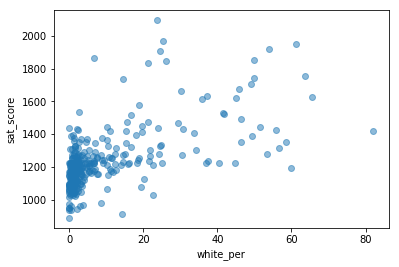

In [44]:
%matplotlib inline
fig3 = plt.figure()
ax3 = fig3.add_subplot(1,1,1)
x=combined['white_per'].values
y=combined['sat_score'].values
ax3.scatter(x,y,alpha=0.5)
ax3.set_xlabel('white_per')
ax3.set_ylabel('sat_score')
plt.show()

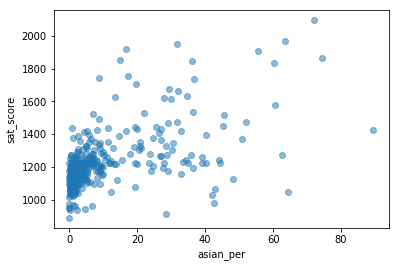

In [45]:
%matplotlib inline
fig4 = plt.figure()
ax4 = fig4.add_subplot(1,1,1)
x=combined['asian_per'].values
y=combined['sat_score'].values
ax4.scatter(x,y,alpha=0.5)
ax4.set_xlabel('asian_per')
ax4.set_ylabel('sat_score')
plt.show()

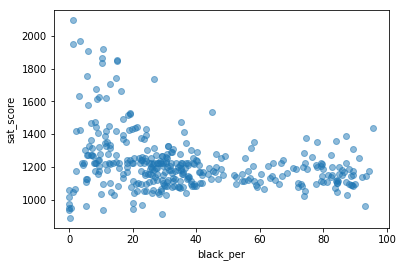

In [46]:
%matplotlib inline
fig5 = plt.figure()
ax5 = fig5.add_subplot(1,1,1)
x=combined['black_per'].values
y=combined['sat_score'].values
ax5.scatter(x,y,alpha=0.5)
ax5.set_xlabel('black_per')
ax5.set_ylabel('sat_score')
plt.show()

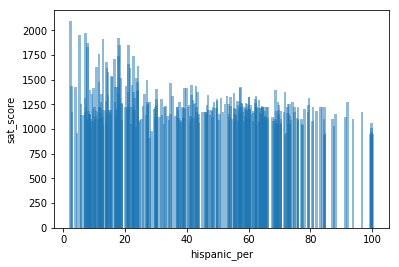

In [47]:
%matplotlib inline
fig6 = plt.figure()
ax6 = fig6.add_subplot(1,1,1)
x=combined['hispanic_per'].values
y=combined['sat_score'].values
ax6.bar(x,y,alpha=0.5)
ax6.set_xlabel('hispanic_per')
ax6.set_ylabel('sat_score')
plt.show()

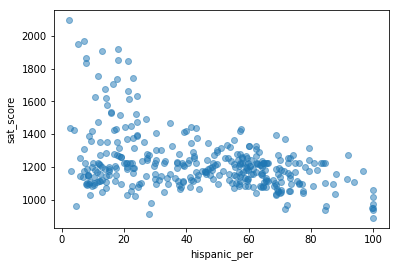

In [48]:
%matplotlib inline
fig7 = plt.figure()
ax7 = fig7.add_subplot(1,1,1)
x=combined['hispanic_per'].values
y=combined['sat_score'].values
ax7.scatter(x,y,alpha=0.5)
ax7.set_xlabel('hispanic_per')
ax7.set_ylabel('sat_score')
plt.show()

# Correlate Gender and SAT

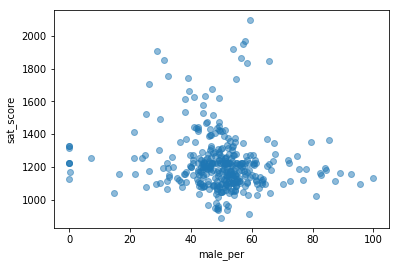

In [49]:
%matplotlib inline
fig8 = plt.figure()
ax8 = fig8.add_subplot(1,1,1)
x=combined['male_per'].values
y=combined['sat_score'].values
ax8.scatter(x,y,alpha=0.5)
ax8.set_xlabel('male_per')
ax8.set_ylabel('sat_score')
plt.show()

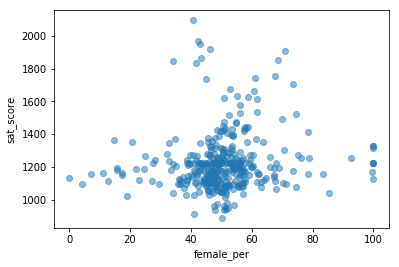

In [50]:
%matplotlib inline
fig9 = plt.figure()
ax9 = fig9.add_subplot(1,1,1)
x=combined['female_per'].values
y=combined['sat_score'].values
ax9.scatter(x,y,alpha=0.5)
ax9.set_xlabel('female_per')
ax9.set_ylabel('sat_score')
plt.show()

In [51]:
combined


,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.000000,404.000000,363.000000,1122.000000,0,129.028846,197.038462,...,Then to New York City residents,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260,01
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.000000,423.000000,366.000000,1172.000000,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797,01
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.000000,402.000000,370.000000,1149.000000,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0,0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041,01
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.000000,433.000000,384.000000,1207.000000,0,129.028846,197.038462,...,0,0,0,0,0,0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673,01
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.000000,574.000000,525.000000,1621.000000,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0,0,0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426,01
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.000000,604.000000,628.000000,1856.000000,0,129.028846,197.038462,...,0,0,0,0,0,0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066,01
6,02M047,47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...,16,395.000000,400.000000,387.000000,1182.000000,0,129.028846,197.038462,...,0,0,0,0,0,0,"223 East 23 Street\nNew York, NY 10010\n(40.73...",40.738599,-73.982512,02
7,02M288,FOOD AND FINANCE HIGH SCHOOL,62,409.000000,393.000000,392.000000,1194.000000,0,129.028846,197.038462,...,0,0,0,0,0,0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02
8,02M294,ESSEX STREET ACADEMY,53,394.000000,384.000000,378.000000,1156.000000,0,129.028846,197.038462,...,0,0,0,0,0,0,"350 Grand Street\nNew York, NY 10002\n(40.7168...",40.716867,-73.989532,02
9,02M296,HIGH SCHOOL OF HOSPITALITY MANAGEMENT,58,374.000000,375.000000,362.000000,1111.000000,High School of Hospitality Management,129.028846,197.038462,...,0,0,0,0,0,0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02


In [52]:
combined['ap_per']=combined['AP Test Takers ']/combined['total_enrollment']

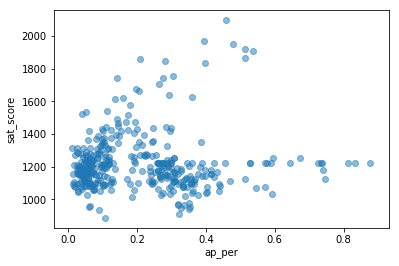

In [53]:
%matplotlib inline
fig10 = plt.figure()
ax10 = fig10.add_subplot(1,1,1)
x=combined['ap_per'].values
y=combined['sat_score'].values
ax10.scatter(x,y,alpha=0.5)
ax10.set_xlabel('ap_per')
ax10.set_ylabel('sat_score')
plt.show()